This is the notebook for some data exploration, feature selection, and model experimentation to predict which hallmark genes are associated with which tumor stage of cancer. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
file_x = '../post/X.csv.gzip'
file_y = '../post/y.csv'
rnaseq_x = pd.read_csv(file_x, compression='gzip')
tumor_y = pd.read_csv(file_y)

In [3]:
rnaseq_x.head()

,Unnamed: 0,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,tcga-2v-a95s-0,22283,584,0,375,0,286320,81,543,1,...,25,274,795,19,500,3173,891,511,4,7
1,tcga-2y-a9gs-1,22642,1573,3,99,0,31169,163,2,1,...,69,633,1154,72,1001,5302,756,861,7,483
2,tcga-2y-a9gt-2,77670,1281,0,215,1,19515,119,1,3,...,47,1220,1134,13,1290,3220,861,524,15,84
3,tcga-2y-a9gu-3,9323,1253,0,2914,2,243941,72,0,0,...,19,286,1151,10,942,3093,1340,344,3,3
4,tcga-2y-a9gv-4,84243,1641,0,404,0,8756,83,0,9,...,42,1000,1632,5,1381,2903,576,666,3,120


In [4]:
tumor_y.head()

,Unnamed: 0,tumor_stage
0,tcga-2v-a95s-0,ii
1,tcga-2y-a9gs-1,not_reported
2,tcga-2y-a9gt-2,i
3,tcga-2y-a9gu-3,i
4,tcga-2y-a9gv-4,i


In [5]:
#Renaming the Unnamed: 0 column to bcr_patient_barcode and setting that 
#to be the index for both datasets 
rnaseq_x = rnaseq_x.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'})
rnaseq_x = rnaseq_x.set_index('bcr_patient_barcode')
tumor_y = tumor_y.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'})
tumor_y = tumor_y.set_index('bcr_patient_barcode')

In [6]:
rnaseq_x.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s-0,22283,584,0,375,0,286320,81,543,1,1032,...,25,274,795,19,500,3173,891,511,4,7
tcga-2y-a9gs-1,22642,1573,3,99,0,31169,163,2,1,903,...,69,633,1154,72,1001,5302,756,861,7,483
tcga-2y-a9gt-2,77670,1281,0,215,1,19515,119,1,3,773,...,47,1220,1134,13,1290,3220,861,524,15,84
tcga-2y-a9gu-3,9323,1253,0,2914,2,243941,72,0,0,722,...,19,286,1151,10,942,3093,1340,344,3,3
tcga-2y-a9gv-4,84243,1641,0,404,0,8756,83,0,9,828,...,42,1000,1632,5,1381,2903,576,666,3,120


In [7]:
tumor_y.head()

,tumor_stage
bcr_patient_barcode,
tcga-2v-a95s-0,ii
tcga-2y-a9gs-1,not_reported
tcga-2y-a9gt-2,i
tcga-2y-a9gu-3,i
tcga-2y-a9gv-4,i


Because the counts of the RNA sequence are hard to interpret, I decided to change them into percentages to get a better reading of which RNA sequence is more significant to each patient. I decided to use the MinMaxScaler in order to achieve this. 

As for the feature selection, I opted to use the Random Forest Classifier's (RFC) feature importance attribute in order to reduce dimensionality on the data. As we can see, we have over 20,000 genes to sort through, so I need to find an efficient way of evaluating the genes that actually matter. Therefore, I'll preemtively train the Random Forest Classifier on the scaled dataset. I'll later on use other models to compare RFC in another hyper-parameter optmization phase. 

That being said, the next step is the hyper-parameter optimization phase in this process. I opted to use a Pipeline and to use Randomized Search in order to find the best model with the best scoring. Why Randomized Search over Grid Search? I'd like to select a random set of values instead of going through every combination for this step of the process. We're focusing on feature selection and not model evaluation at this stage, so I opted to speed up the process here for optimization at this stage of the process. I'll be looking observing and tuning all of the best values for each paramater in the RFC. In order to achieve a smooth process for the model evaluation later on, I created a "SwitchClassifier" class to switch between the other models.

In [16]:
from sklearn.base import BaseEstimator 
from sklearn.naive_bayes import MultinomialNB

class SwitchClassifier(BaseEstimator):
    
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier 
    
    def fit(self, X, y=None, **kwargs): 
        self.classifier.fit(X, y)
        return self 
    
    def predict(self, X, y=None):
        self.classifier.predict(X)
    
    def predict_proba(self, X, y=None):
        return self.classifier.predict_proba(X)
    
    def score(self, X, y=None):
        return self.classifier.score(X, y)
            

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split

pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                 ('classifier', RandomForestClassifier())])
               
params =  {'classifier': [RandomForestClassifier()], 
         'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
         'classifier__max_features': ['auto', 'sqrt'],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)], 
         'classifier__max_depth': [int(x) for x in np.linspace(start=10, stop=110, num=11)],
         'classifier__bootstrap': [True, False]}
    

rnaseq_x_train, rnaseq_x_test, tumor_y_train, tumor_y_test = train_test_split(rnaseq_x, np.ravel(tumor_y),
                                                                                 random_state=42)

rscv = RandomizedSearchCV(pipe, params, n_iter=100, verbose=2, cv=3, random_state=42, n_jobs=-1)
rscv.fit(rnaseq_x_train, tumor_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 60.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessing',
                                              MinMaxScaler(copy=True,
                                                           feature_range=(0,
                                                                          1))),
                                             ('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                      

In [21]:
#saving the model for later use. 
import pickle 
random_forest_best = rscv.best_params_['classifier']
filename = 'random_forest_best.sav'
rfcb_saved = pickle.dump(random_forest_best, open(filename, 'wb'))
rfcb_loaded = pickle.load(open(filename, 'rb'))

In [14]:
print("Best parameters:\n{}\n".format(rscv.best_params_))

Best parameters:
{'preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)), 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 50, 'classifier__bootstrap': False, 'classifier': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}



In [81]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV


sfm = SelectFromModel(random_forest_best, threshold='median')
sfm.fit(rnaseq_x_train, tumor_y_train)

rnaseq_x_important_train = sfm.transform(rnaseq_x_train)
rnaseq_x_important_test = sfm.transform(rnaseq_x_test)

sfm_mask = sfm.get_support(indices=True)

def grid_search_process(df_x_train, df_y_train):
    pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                     ('classifier', SwitchClassifier())])

    param_grid = [ 
            {'classifier': [MultinomialNB()], 'preprocessing': [MinMaxScaler(feature_range=(0, 1))], 
             'classifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}, 
            {'classifier': [SGDClassifier()], 'preprocessing': [MinMaxScaler(feature_range=(0, 1))], 
             'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
             'classifier__penalty': ['l2', 'l1', 'elasticnet'], 
             'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
            {'classifier': [RandomForestClassifier()], 
             'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
             'classifier__max_features': ['sqrt'],
             'classifier__min_samples_split': [2],
             'classifier__min_samples_leaf': [1],
             'classifier__n_estimators': [200], 
             'classifier__max_depth': [50],
             'classifier__bootstrap': [False]}
        ]

    grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(df_x_train, df_y_train)
    return grid_search

grid_search = grid_search_process(rnaseq_x_important_train, tumor_y_train)

In [82]:
# from sklearn.feature_selection import SelectFromModel
# from matplotlib import pyplot as plt
print("Best parameters:\n{}\n".format(grid_search.best_params_['classifier']))
print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_*100))
print("Test-set score: {:.2f}%".format(grid_search.score(rnaseq_x_important_test, tumor_y_test)*100))

Best parameters:
SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='modified_huber', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Best cross-validation score: 48.25%
Test-set score: 47.17%


In [83]:
clf_best = grid_search.best_params_['classifier']
filename = 'clf_best_1.sav'
clfb_saved = pickle.dump(clf_best, open(filename, 'wb'))
clfb_loaded = pickle.load(open(filename, 'rb'))

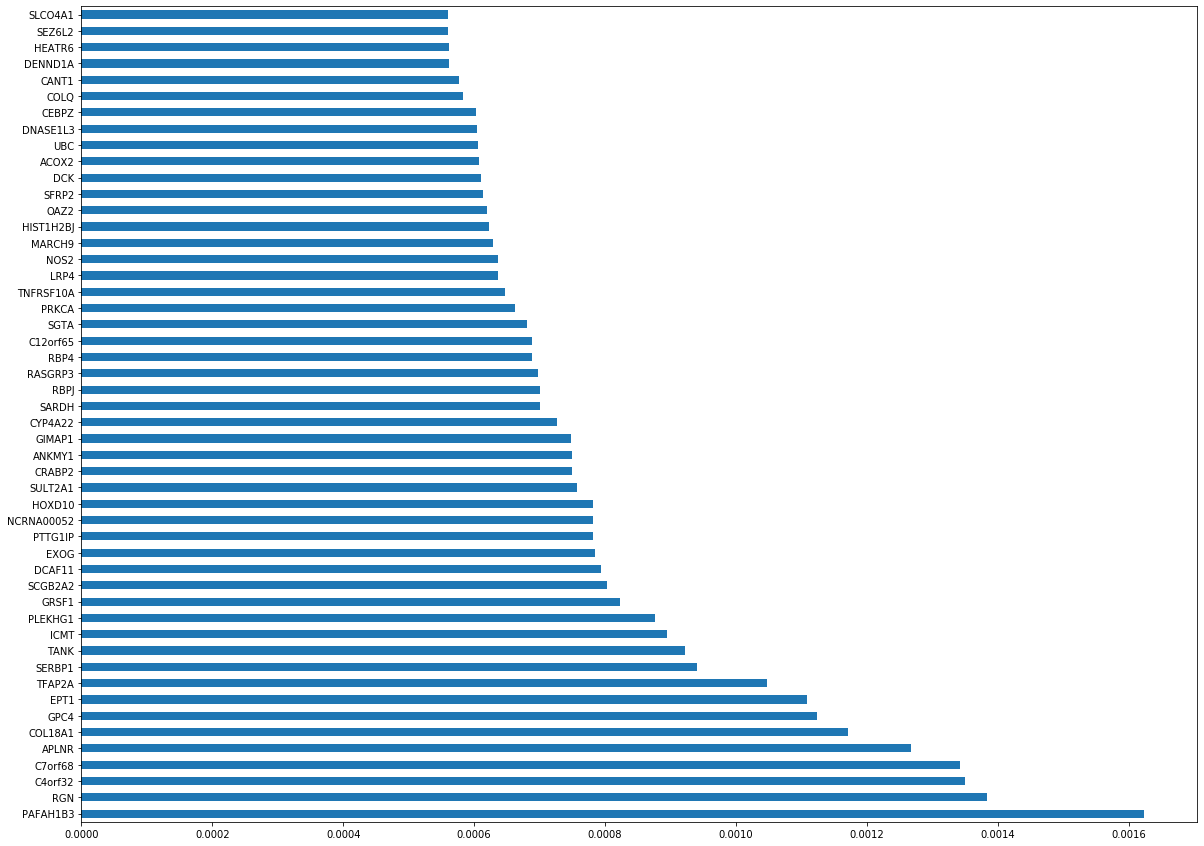

In [44]:
from matplotlib import pyplot as plt

random_forest_best_feature_importances = rscv.best_estimator_['classifier'].feature_importances_
feature_importances_series = pd.Series(random_forest_best_feature_importances, index=rnaseq_x.columns)
feature_importances_series.nlargest(50).plot(figsize=(20, 15), kind='barh')

As we can see from the top 50 largest feature importance percentages, the gene PAFAH1B3 has the biggest by far with a percentage of ~0.16. I mainly wanted to visualize this to show off the range of percentages of feature relevance we are dealing in the dataset to set up my reasoning for using a small percentage for SelectPercentile. Due to the fact that we are dealing with 20,000+ features and the most relevant feature has a feature relevance percentage of 0.16%, we'll just consider the top 10% of features, as anything below that threshold will be too irrelevant for model prediction and evaluation. 

I'll be reusing the same code for the SelectFromModel process as from before

In [84]:
from sklearn.feature_selection import SelectPercentile 


sfm = SelectPercentile(percentile=10)
sfm.fit(rnaseq_x_train, tumor_y_train)

rnaseq_x_important_train = sfm.transform(rnaseq_x_train)
rnaseq_x_important_test = sfm.transform(rnaseq_x_test)

grid_search_2 = grid_search_process(rnaseq_x_important_train, tumor_y_train)
print("Best parameters:\n{}\n".format(grid_search_2.best_params_['classifier']))
print("Best cross-validation score: {:.2f}%".format(grid_search_2.best_score_*100))
print("Test-set score: {:.2f}%".format(grid_search_2.score(rnaseq_x_important_test, tumor_y_test)*100))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [3711 3902] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best parameters:
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='squared_hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

Best cross-validation score: 52.05%
Test-set score: 40.57%


In [93]:
clf_best_2 = grid_search_2.best_params_['classifier']
filename = 'clf_best_2.sav'
clfb_saved_2 = pickle.dump(clf_best, open(filename, 'wb'))
clfb_loaded_2 = pickle.load(open(filename, 'rb'))

In [49]:
import pickle 
hallmark_dict = pickle.load(open('hallmarks_of_cancer_geneset_dictionary.pkl','rb'))
hallmark_dict

{'HALLMARK_ADIPOGENESIS': array(['ABCA1', 'ABCB8', 'ACAA2', 'ACADL', 'ACADM', 'ACADS', 'ACLY',
        'ACO2', 'ACOX1', 'ADCY6', 'ADIG', 'ADIPOQ', 'ADIPOR2', 'AGPAT3',
        'AIFM1', 'AK2', 'ALDH2', 'ALDOA', 'ANGPT1', 'ANGPTL4', 'APLP2',
        'APOE', 'ARAF', 'ARL4A', 'ATL2', 'ATP1B3', 'ATP5PO', 'BAZ2A',
        'BCKDHA', 'BCL2L13', 'BCL6', 'C3', 'CAT', 'CAVIN1', 'CAVIN2',
        'CCNG2', 'CD151', 'CD302', 'CD36', 'CDKN2C', 'CHCHD10', 'CHUK',
        'CIDEA', 'CMBL', 'CMPK1', 'COL15A1', 'COL4A1', 'COQ3', 'COQ5',
        'COQ9', 'COX6A1', 'COX7B', 'COX8A', 'CPT2', 'CRAT', 'CS', 'CYC1',
        'CYP4B1', 'DBT', 'DDT', 'DECR1', 'DGAT1', 'DHCR7', 'DHRS7',
        'DHRS7B', 'DLAT', 'DLD', 'DNAJB9', 'DNAJC15', 'DRAM2', 'ECH1',
        'ECHS1', 'ELMOD3', 'ELOVL6', 'ENPP2', 'EPHX2', 'ESRRA', 'ESYT1',
        'ETFB', 'FABP4', 'FAH', 'FZD4', 'G3BP2', 'GADD45A', 'GBE1',
        'GHITM', 'GPAM', 'GPAT4', 'GPD2', 'GPHN', 'GPX3', 'GPX4', 'GRPEL1',
        'HADH', 'HIBCH', 'HSPB8', 'IDH1', 'IDH3

In [52]:
hallmark_gene_arr = []
for hallmark, arr in hallmark_dict.items(): 
    for gene in arr:
        if gene not in hallmark_gene_arr:
            hallmark_gene_arr.append(gene)

len(hallmark_gene_arr)

4384

In [85]:
def feature_selector(features_to_select, df): 
    new_df = pd.DataFrame()
    for features in features_to_select: 
        if features in df.columns: 
            new_df[features] = df[features].values
    return new_df

rnaseq_x_important_df = feature_selector(hallmark_gene_arr, rnaseq_x)

rnaseq_x_important_df.head()

,ABCA1,ABCB8,ACAA2,ACADL,ACADM,ACADS,ACLY,ACO2,ACOX1,ADCY6,...,SLC12A4,SLC22A1,SLC35B1,SLC46A3,SPINT2,SSR3,TAT,TTPA,UPB1,XDH
0,1151,1147,5643,3,1813,1319,2280,2402,3516,1590,...,621,27,1989,302,252,3933,228,189,2975,535
1,1249,1334,14341,622,4145,1656,2788,3503,7663,938,...,946,8681,1814,600,1282,4420,13498,578,5048,2039
2,3133,909,11906,981,4591,1551,1502,2986,9067,1509,...,1550,32442,1726,4113,141,2914,56697,879,4920,5190
3,1748,1569,11053,9,4510,4736,2615,14736,9344,1895,...,1123,9061,2927,724,44,5475,17140,121,11803,8372
4,2885,907,9380,915,4971,4489,3119,2862,8693,826,...,1348,28187,1596,5328,142,3368,14384,1390,6469,3506


In [90]:
rnaseq_x_train, rnaseq_x_test, tumor_y_train, tumor_y_test = train_test_split(rnaseq_x_important_df, np.ravel(tumor_y),
                                                                                 random_state=42)
grid_search_3 = grid_search_process(rnaseq_x_train, tumor_y_train)
print("Best parameters:\n{}\n".format(grid_search_3.best_params_['classifier']))
print("Best cross-validation score: {:.2f}%".format(grid_search_3.best_score_*100))
print("Test-set score: {:.2f}%".format(grid_search_3.score(rnaseq_x_test, tumor_y_test)*100))

Best parameters:
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Best cross-validation score: 46.65%
Test-set score: 40.57%


In [92]:
clf_best_3 = grid_search_3.best_params_['classifier']
filename = 'clf_best_3.sav'
clfb_saved_3 = pickle.dump(clf_best, open(filename, 'wb'))
clfb_loaded_3 = pickle.load(open(filename, 'rb'))